In [20]:
import os
import cv2
import sys
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from google.colab.patches import cv2_imshow

In [21]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


LOAD LABELS DATASET

In [22]:
df = pd.read_csv('/content/gdrive/MyDrive/Dataset Boxing.csv')

CREATE LABELS LIST FOR MULTILABEL CLASSIFICATION

In [23]:
moves_per_video = 5
move_labels = []

viable_moves = df['Move Type'].unique()
viable_moves = viable_moves[:len(viable_moves)-3]
print(viable_moves)

for i in range(df.shape[0]):
  if df['Move Type'].iloc[i] in viable_moves:
    for j in range(moves_per_video):
      move_labels.append(df['Move Type'].iloc[i])

['ready stance' 'jab' 'cross' 'lead hook' 'rear hook' 'lead uppercut'
 'rear uppercut']


NOMINAL TO CATEGORICAL

In [24]:
# Converting labels from nominal values to binary categorical

y=[]

for i in range(len(move_labels)):
  for j in range(len(viable_moves)):
    if move_labels[i] == viable_moves[j]:
      y.append(j)

y_cat = to_categorical(y, num_classes=7)

for i, label in  enumerate(viable_moves):
    print(f"Binary line {i + 1} corresponds to label: {label}")

Binary line 1 corresponds to label: ready stance
Binary line 2 corresponds to label: jab
Binary line 3 corresponds to label: cross
Binary line 4 corresponds to label: lead hook
Binary line 5 corresponds to label: rear hook
Binary line 6 corresponds to label: lead uppercut
Binary line 7 corresponds to label: rear uppercut


LOAD THE LANDMARKS FILES

In [25]:
# FRONT VIEW

with open('/content/gdrive/MyDrive/Landmarks/front/front_final_landmarks.pkl', 'rb') as file:
    front_data = pickle.load(file)

with open('/content/gdrive/MyDrive/Landmarks/front_1.5/front_1.5_final_landmarks.pkl', 'rb') as file:
    front_15_data = pickle.load(file)

with open('/content/gdrive/MyDrive/Landmarks/front_2/front_2_final_landmarks.pkl', 'rb') as file:
    front_2_data = pickle.load(file)

with open('/content/gdrive/MyDrive/Landmarks/front_4/front_4_final_landmarks.pkl', 'rb') as file:
    front_4_data = pickle.load(file)

In [26]:
# SIDE VIEW

with open('/content/gdrive/MyDrive/Landmarks/side/side_final_landmarks.pkl', 'rb') as file:
    side_data = pickle.load(file)

with open('/content/gdrive/MyDrive/Landmarks/side_1.5/side_1.5_final_landmarks.pkl', 'rb') as file:
    side_15_data = pickle.load(file)

with open('/content/gdrive/MyDrive/Landmarks/side_2/side_2_final_landmarks.pkl', 'rb') as file:
    side_2_data = pickle.load(file)

with open('/content/gdrive/MyDrive/Landmarks/side_4/side_4_final_landmarks.pkl', 'rb') as file:
    side_4_data = pickle.load(file)

HELPING FUNCTIONS

In [27]:
def train_validation_test_split(data, labels, random_state):
  """
  Splits the input data and labels into training, validation, and testing sets.

  Args:
      data (array-like): Input data to be split into training, validation, and testing sets.
      labels (array-like): Corresponding labels for the input data.
      random_state (int): Seed value for reproducibility.

  Returns:
      tuple: A tuple containing:
          - x_train (array-like): Training data.
          - x_validation (array-like): Validation data.
          - x_test (array-like): Testing data.
          - y_train (array-like): Labels for training data.
          - y_validation (array-like): Labels for validation data.
          - y_test (array-like): Labels for testing data.
  """

  x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random_state, stratify=labels)
  x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=random_state, stratify=y_test)

  x_train = np.array(x_train)
  x_test = np.array(x_test)
  x_validation = np.array(x_validation)

  return x_train, x_validation, x_test, y_train, y_validation, y_test

In [28]:
def plot_average_train_valid_results(histories):
    """
    Plots the training and validation accuracy and loss over epochs.

    Args:
        histories (list): A list of history objects containing training and validation metrics.

    Returns:
        None
    """

    avg_loss = []
    avg_val_loss = []
    avg_accuracy = []
    avg_val_accuracy = []

    # Loop through each history object in the list
    for history in histories:
        avg_loss.append(history.history['loss'])
        avg_val_loss.append(history.history['val_loss'])
        avg_accuracy.append(history.history['accuracy'])
        avg_val_accuracy.append(history.history['val_accuracy'])

    # Calculate averages
    avg_loss = np.mean(avg_loss, axis=0)
    avg_val_loss = np.mean(avg_val_loss, axis=0)
    avg_accuracy = np.mean(avg_accuracy, axis=0)
    avg_val_accuracy = np.mean(avg_val_accuracy, axis=0)

    # Plot average training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(avg_loss, label='Average Training Loss')
    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.title('Average Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot average training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(avg_accuracy, label='Average Training Accuracy')
    plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
    plt.title('Average Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [29]:
def average_accuracy_boxplots(metrics_list, title):
    """
    Plots the boxplot of accuracies.

    Args:
        metrics_list (list): A list of tuples containing accuracy values for different models.
                             Each tuple should contain the accuracy value as its first element.
        title (str): Title for the plot.

    Returns:
        list: A list containing accuracy values extracted from metrics_list.
    """

    # Extract accuracy values from metrics_list
    accuracy_values = [metrics[0] for metrics in metrics_list]

    # Calculate average accuracy
    average_accuracy = sum(accuracy_values) / len(accuracy_values)

    # Print average accuracy
    print(f"Average Accuracy across Models: {average_accuracy}")

    # Create a boxplot for accuracy values
    sns.boxplot(y=accuracy_values)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.show()
    return accuracy_values

In [30]:
def average_loss_boxplots(metrics_list, title):
    """
    Plots the boxplot of losses.

    Args:
        metrics_list (list): A list of tuples containing loss values for different models.
                             Each tuple should contain the loss value as its second element.
        title (str): Title for the plot.

    Returns:
        list: A list containing loss values extracted from metrics_list.
    """

    # Extract loss values from metrics_list
    loss_values = [metrics[1] for metrics in metrics_list]

    # Calculate average loss
    average_loss = sum(loss_values) / len(loss_values)

    # Print average loss
    print(f"Average Loss across Models: {average_loss}")

    # Create a boxplot for loss values
    sns.boxplot(y=loss_values)
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Model')
    plt.show()
    return loss_values

In [31]:
def calculate_average_class_report(metrics_lists):
    """
    Computes the average metrics Precision, Recall, and F1-Score.

    Args:
         metrics_list (list): A list of tuples containing metrics for different experiments

    Returns:
        None
    """

    classification_reports = [metrics[2] for metrics in metrics_lists]
    num_classes = len(classification_reports[0])
    num_runs = len(classification_reports)

    # Initialize lists to store sum of metrics for each class
    sum_precision = [0] * num_classes
    sum_recall = [0] * num_classes
    sum_f1 = [0] * num_classes

    # Sum up the metrics for each class across all runs
    for metrics_list in classification_reports:
        for i, metrics_dict in enumerate(metrics_list):
            sum_precision[i] += metrics_dict['Precision']
            sum_recall[i] += metrics_dict['Recall']
            sum_f1[i] += metrics_dict['F1 Score']

    # Calculate average metrics for each class
    avg_precision = [sum_p / num_runs for sum_p in sum_precision]
    avg_recall = [sum_r / num_runs for sum_r in sum_recall]
    avg_f1 = [sum_f / num_runs for sum_f in sum_f1]

    # Create a list of dictionaries for the average metrics
    avg_metrics_list = []
    for i in range(num_classes):
        avg_metrics_dict = {
            'Class': i + 1,
            'Average Precision': avg_precision[i],
            'Average Recall': avg_recall[i],
            'Average F1 Score': avg_f1[i]
        }
        avg_metrics_list.append(avg_metrics_dict)

    # Print the average metrics for each class
    for avg_metrics_dict in avg_metrics_list:
        print(f"Class {avg_metrics_dict['Class']}: Average Precision={avg_metrics_dict['Average Precision']:.4f}, Average Recall={avg_metrics_dict['Average Recall']:.4f}, Average F1 Score={avg_metrics_dict['Average F1 Score']:.4f}")

In [32]:
def sum_confusion_matrix(metrics_list, title):
    """
    Computes the summed confusion matrix.

    Args:
        metrics_list (list): A list of tuples containing metrics for different experiments
        title (str): Title for the plot.

    Returns:
        None
    """

    # Extract confusion matrices from metrics_list
    confusion_matrices = [metrics[3] for metrics in metrics_list]

    # Calculate the sum of confusion matrices element-wise
    sum_confusion_matrix = np.sum(confusion_matrices, axis=0)

    # disp = ConfusionMatrixDisplay(average_confusion_matrix, display_labels=viable_moves)
    disp = ConfusionMatrixDisplay(sum_confusion_matrix, display_labels=viable_moves)

    disp.plot()
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

In [33]:
def evaluate_model(model, x_test, y_test):
    """
    Evaluates the testing set and returns a list with different metrics.

    Args:
        model (tf.keras.Model): The trained model to be evaluated.
        x_test (array-like): Testing data.
        y_test (array-like): Ground truth labels for the testing data.

    Returns:
        tuple: A tuple containing:
            - accuracy (float): Accuracy of the model on the testing set.
            - loss (float): Loss of the model on the testing set.
            - class_report (list): A list of dictionaries containing precision, recall, and F1 score for each class.
            - conf_matrix (array-like): Confusion matrix of the model's predictions on the testing set.
    """

    loss,accuracy = model.evaluate(x_test,y_test)

    y_pred = []

    for i in model.predict(x_test):
        y_pred.append(np.argmax(np.array(i)).astype("int32"))

    y_test_reverted = np.argmax(y_test, axis=1)

    precision = precision_score(y_test_reverted, y_pred, average=None)
    recall = recall_score(y_test_reverted, y_pred, average=None)
    f1 = f1_score(y_test_reverted, y_pred, average=None)

    class_report = []
    for i in range(len(precision)):
        metrics_dict = {
            'Class': i + 1,
            'Precision': precision[i],
            'Recall': recall[i],
            'F1 Score': f1[i]
        }
        class_report.append(metrics_dict)


    conf_matrix = confusion_matrix(y_test_reverted, y_pred)

    return accuracy, loss, class_report, conf_matrix

In [34]:
def make_model(x_train, y_train):
    """
    Constructs and compiles the neural network model.

    Args:
        x_train (array-like): Training data.
        y_train (array-like): Labels for the training data.

    Returns:
        tf.keras.Model: Compiled LSTM-based neural network model.
    """

    n_timesteps = np.shape(x_train)[1]
    n_features = np.shape(x_train)[2]
    n_outputs = np.shape(y_train)[1]

    model = Sequential()
    model.add(Masking(mask_value=-10, input_shape=(n_timesteps, n_features))) # a Masking layer before LSTM layer to ignore the padded timestamps,
    model.add(LSTM(64, return_sequences=True, input_shape=(n_timesteps,n_features))) # Default activation="tanh", experiment with activation='relu'
    model.add(Dropout(0.2))
    model.add(LSTM(128)) # Default activation="tanh", experiment with activation='relu'
    model.add(Dropout(0.2)) # a dropout layer intended to reduce overfitting of the model to the training data
    model.add(Dense(64, activation='relu')) # experiment with this
    model.add(Dense(n_outputs, activation='softmax')) #'softmax' for multi-class

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [35]:
def save_model(model):
    """
    Saves the trained model.

    Args:
        model (tf.keras.Model): The trained model to be saved.

    Returns:
        None
    """
    model.save('/content/gdrive/MyDrive/side_model.keras')


In [40]:
def fit_model(model, x_train, y_train, x_validation, y_validation):
    """
    Fits the model with the training data.

    Args:
        model (tf.keras.Model): The model to be trained.
        x_train (array-like): Training data.
        y_train (array-like): Ground truth labels for the training data.
        x_validation (array-like): Validation data.
        y_validation (array-like): Ground truth labels for the validation data.

    Returns:
        tf.keras.callbacks.History: History object containing training metrics.
    """
    history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_validation,y_validation),verbose=0)
    return history

In [37]:
def run_experiment(num_iterations, view):
    """
    Runs an experiment with the specified number of iterations and view.

    Args:
        num_iterations (int): Number of iterations for the experiment.
        view (str): View of the videos ('front' or 'side').

    Returns:
        None
    """
    history_list = []
    metrics_list = []
    metrics_list_15 = []
    metrics_list_2 = []
    metrics_list_4 = []

    for i in range(num_iterations):
      if view == 'front':
        X_train, X_validation, X_test, y_train, y_validation, y_test = train_validation_test_split(front_data, y_cat, i)
        _, _, X_test15, _, _, y_test15 =  train_validation_test_split(front_15_data, y_cat, i)
        _, _, X_test2, _, _, y_test2 = train_validation_test_split(front_2_data, y_cat, i)
        _, _, X_test4, _, _, y_test4 = train_validation_test_split(front_4_data, y_cat, i)
      elif view == 'side':
        X_train, X_validation, X_test, y_train, y_validation, y_test = train_validation_test_split(side_data, y_cat, i)
        _, _, X_test15, _, _, y_test15 = train_validation_test_split(side_15_data, y_cat, i)
        _, _, X_test2, _, _, y_test2 = train_validation_test_split(side_2_data, y_cat, i)
        _, _, X_test4, _, _, y_test4 = train_validation_test_split(side_4_data, y_cat, i)

      model = make_model(X_train, y_train)
      history = fit_model(model, X_train, y_train, X_validation, y_validation)
      history_list.append(history)
      metrics_list.append(list(evaluate_model(model, X_test, y_test)))
      metrics_list_15.append(list(evaluate_model(model, X_test15, y_test15)))
      metrics_list_2.append(list(evaluate_model(model, X_test2, y_test2)))
      metrics_list_4.append(list(evaluate_model(model, X_test4, y_test4)))

      print('\n Iteration ', i+1, " finished")

    save_model(model)

    plot_average_train_valid_results(history_list)

    print("\nResults for original quality\n")
    ac = average_accuracy_boxplots(metrics_list, 'Boxplot of Model Accuracies for videos of original quality')
    l = average_loss_boxplots(metrics_list, 'Boxplot of Model Losses for videos of original quality')
    sum_confusion_matrix(metrics_list, 'Summed Confusion matrix for videos of original quality')
    calculate_average_class_report(metrics_list)

    print("\nResults for 1.5 times downgraded quality\n")
    ac = average_accuracy_boxplots(metrics_list_15, 'Boxplot of Model Accuracies for videos of 1.5 times downgraded quality')
    l = average_loss_boxplots(metrics_list_15, 'Boxplot of Model Losses for videos of 1.5 times downgraded quality')
    sum_confusion_matrix(metrics_list_15, 'Summed Confusion matrix for videos of 1.5 times downgraded quality')
    calculate_average_class_report(metrics_list_15)

    print("\nResults for 2 times downgraded quality\n")
    ac = average_accuracy_boxplots(metrics_list_2, 'Boxplot of Model Accuracies for videos of 1.5 times downgraded quality')
    l = average_loss_boxplots(metrics_list_2, 'Boxplot of Model Losses for videos of 2 times downgraded quality')
    sum_confusion_matrix(metrics_list_2, 'Summed Confusion matrix for videos of 2 times downgraded quality')
    calculate_average_class_report(metrics_list_2)

    print("\nResults for 4 times downgraded quality\n")
    ac = average_accuracy_boxplots(metrics_list_4, 'Boxplot of Model Accuracies for videos of 4 times downgraded quality')
    l = average_loss_boxplots(metrics_list_4, 'Boxplot of Model Losses for videos of 4 times downgraded quality')
    sum_confusion_matrix(metrics_list_4, 'Summed Confusion matrix for videos of 4 times downgraded quality')
    calculate_average_class_report(metrics_list_4)


MAIN

2/2 [==============================] - 0s 14ms/step

 Iteration  1  finished
2/2 [==============================] - 0s 11ms/step

 Iteration  2  finished
2/2 [==============================] - 0s 12ms/step

 Iteration  3  finished
2/2 [==============================] - 0s 12ms/step

 Iteration  4  finished
2/2 [==============================] - 0s 11ms/step

 Iteration  5  finished
2/2 [==============================] - 0s 15ms/step

 Iteration  6  finished
2/2 [==============================] - 0s 10ms/step

 Iteration  7  finished
2/2 [==============================] - 0s 11ms/step

 Iteration  8  finished
2/2 [==============================] - 0s 10ms/step

 Iteration  9  finished
2/2 [==============================] - 0s 10ms/step

 Iteration  10  finished


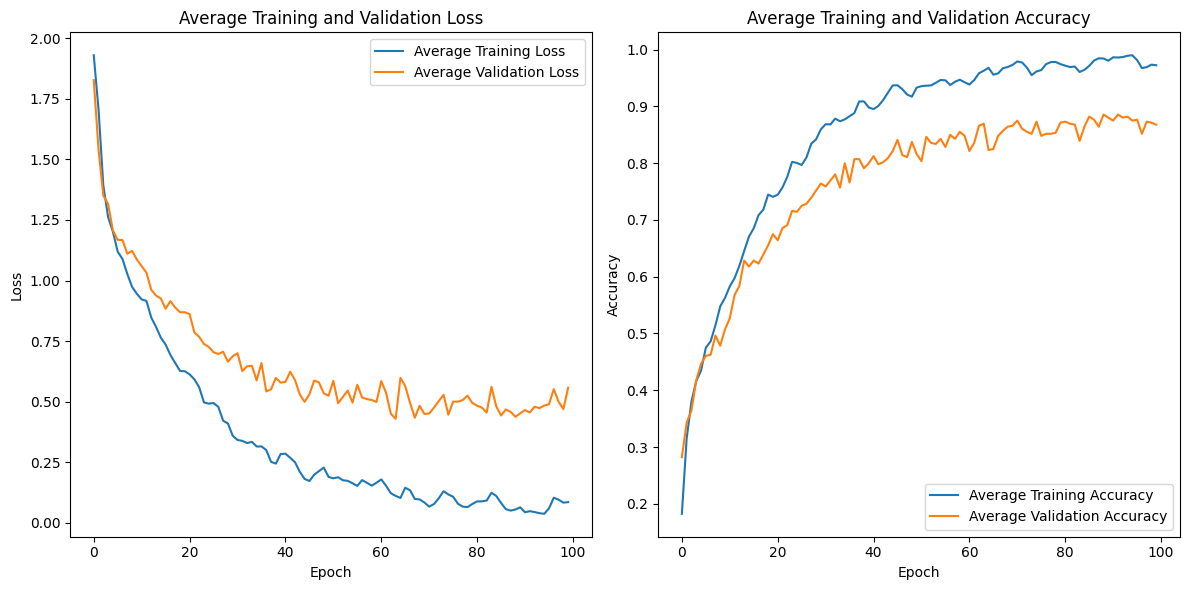


Results for original quality

Average Accuracy across Models: 0.8750000059604645


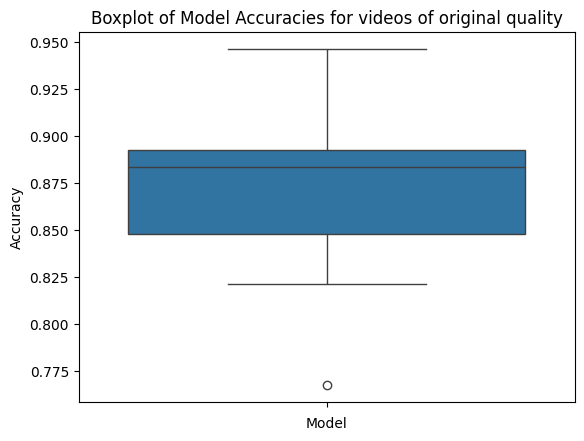

Average Loss across Models: 0.464894562959671


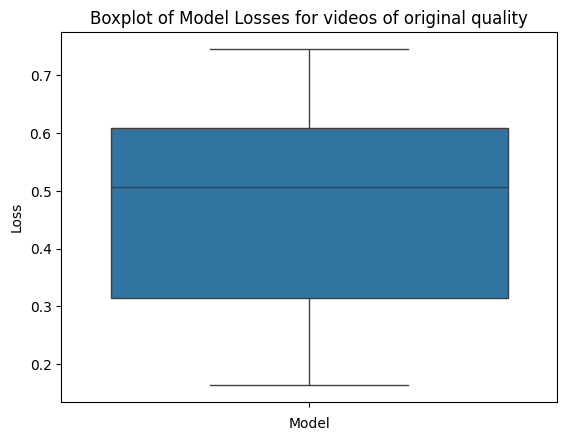

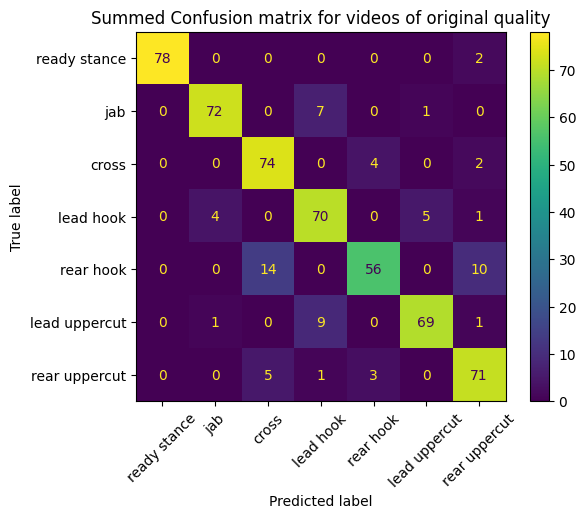

Class 1: Average Precision=1.0000, Average Recall=0.9750, Average F1 Score=0.9867
Class 2: Average Precision=0.9417, Average Recall=0.9000, Average F1 Score=0.9133
Class 3: Average Precision=0.8228, Average Recall=0.9250, Average F1 Score=0.8632
Class 4: Average Precision=0.8223, Average Recall=0.8750, Average F1 Score=0.8381
Class 5: Average Precision=0.8897, Average Recall=0.7000, Average F1 Score=0.7725
Class 6: Average Precision=0.9292, Average Recall=0.8625, Average F1 Score=0.8877
Class 7: Average Precision=0.8268, Average Recall=0.8875, Average F1 Score=0.8497

Results for 1.5 times downgraded quality

Average Accuracy across Models: 0.8767857193946839


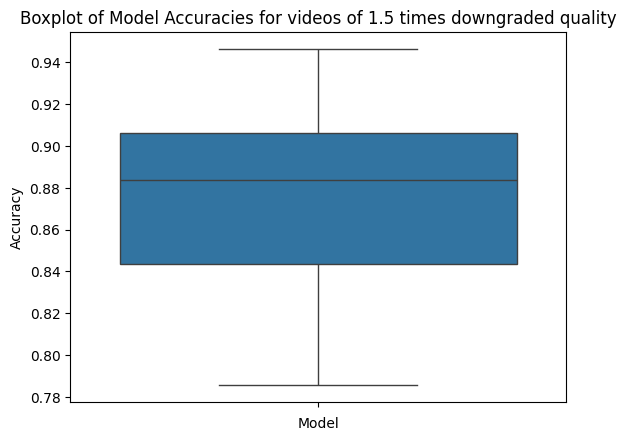

Average Loss across Models: 0.4761924833059311


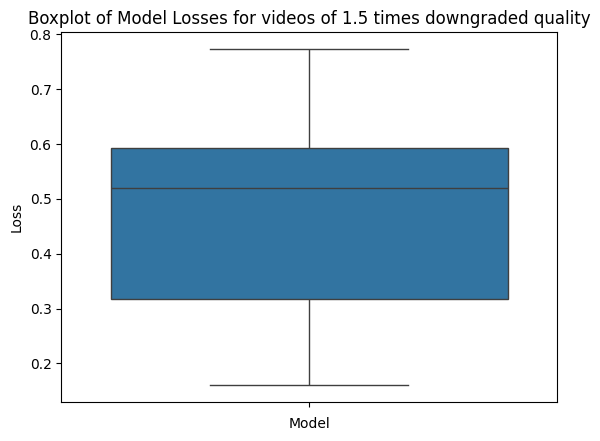

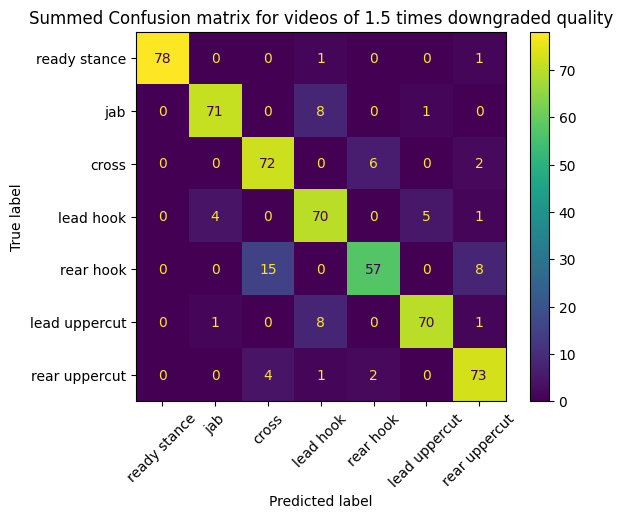

Class 1: Average Precision=1.0000, Average Recall=0.9750, Average F1 Score=0.9867
Class 2: Average Precision=0.9417, Average Recall=0.8875, Average F1 Score=0.9031
Class 3: Average Precision=0.8167, Average Recall=0.9000, Average F1 Score=0.8472
Class 4: Average Precision=0.8205, Average Recall=0.8750, Average F1 Score=0.8367
Class 5: Average Precision=0.8824, Average Recall=0.7125, Average F1 Score=0.7763
Class 6: Average Precision=0.9256, Average Recall=0.8750, Average F1 Score=0.8946
Class 7: Average Precision=0.8597, Average Recall=0.9125, Average F1 Score=0.8801

Results for 2 times downgraded quality

Average Accuracy across Models: 0.8839285731315613


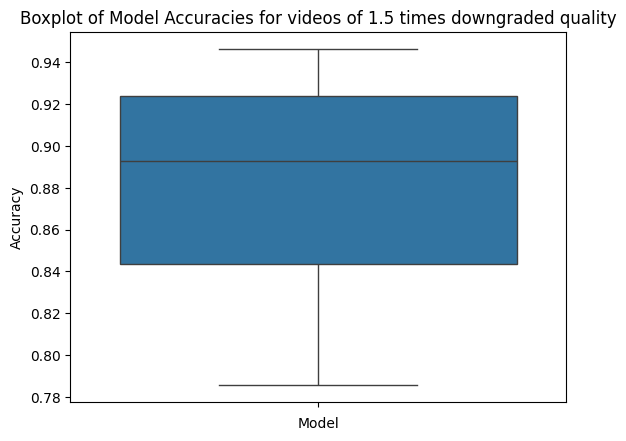

Average Loss across Models: 0.45440372079610825


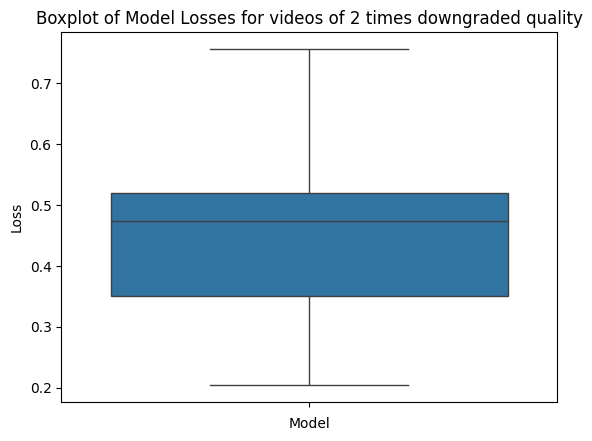

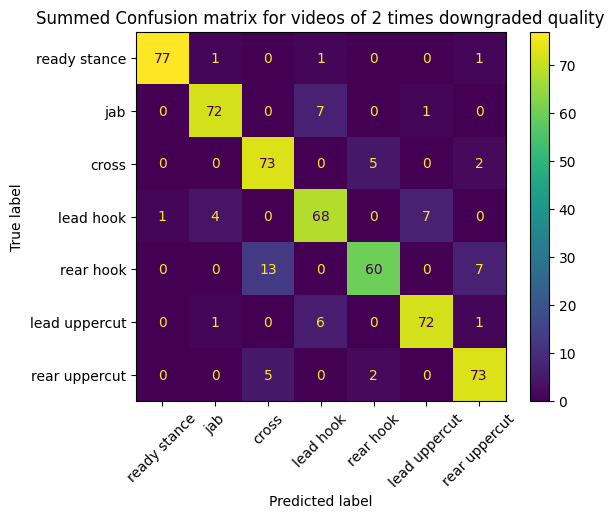

Class 1: Average Precision=0.9875, Average Recall=0.9625, Average F1 Score=0.9742
Class 2: Average Precision=0.9328, Average Recall=0.9000, Average F1 Score=0.9081
Class 3: Average Precision=0.8289, Average Recall=0.9125, Average F1 Score=0.8598
Class 4: Average Precision=0.8502, Average Recall=0.8500, Average F1 Score=0.8407
Class 5: Average Precision=0.8996, Average Recall=0.7500, Average F1 Score=0.8059
Class 6: Average Precision=0.9074, Average Recall=0.9000, Average F1 Score=0.8986
Class 7: Average Precision=0.8728, Average Recall=0.9125, Average F1 Score=0.8869

Results for 4 times downgraded quality

Average Accuracy across Models: 0.8464285671710968


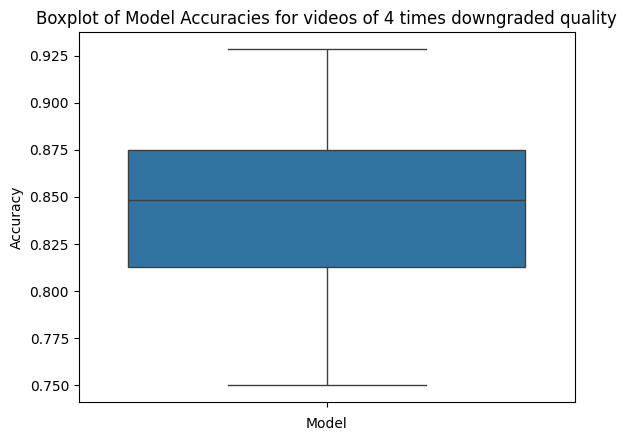

Average Loss across Models: 0.6082382380962372


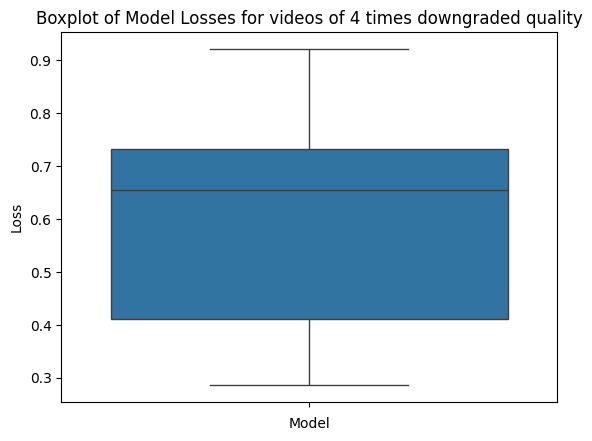

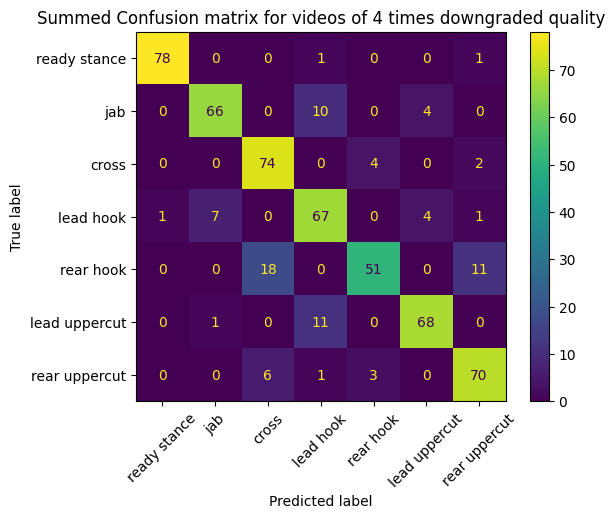

Class 1: Average Precision=0.9889, Average Recall=0.9750, Average F1 Score=0.9808
Class 2: Average Precision=0.9004, Average Recall=0.8250, Average F1 Score=0.8529
Class 3: Average Precision=0.7716, Average Recall=0.9250, Average F1 Score=0.8367
Class 4: Average Precision=0.7588, Average Recall=0.8375, Average F1 Score=0.7852
Class 5: Average Precision=0.8838, Average Recall=0.6375, Average F1 Score=0.7367
Class 6: Average Precision=0.9060, Average Recall=0.8500, Average F1 Score=0.8718
Class 7: Average Precision=0.8266, Average Recall=0.8750, Average F1 Score=0.8383


In [38]:
num_of_iterations = 10
run_experiment(num_of_iterations, 'side')